## Robust PCA

The following algorithm is from the article [1]. For more details, please see the original article.

Consider the following augmented Lagrangian
$$l(L, S,Y) = \|L\|_{*} + λ\|S\|_{1} + \left<Y, M − L− S\right>+ \frac{\mu}{2}\|M − L− S\|_{F}^2$$

---------------------------------------------------------------------------------
**ALGORITHM:** (Principal Component Pursuitby Alternating Directions):
* initialize: $S_0$ = Y_0 = 0$, \mu > 0$.
* **while** not converged do
    * compute $L_{k+1} = D_{1/\mu} (M − S_k + \mu^{-1} Y_k )$;
    * compute $S_{k+1} = S \lambda/\mu (M − L_{k+1} + \mu^{-1} Y_k )$;
    * compute $Y_{k+1} = Y_k + \mu(M − L_{k+1} − S_{k+1})$;
* end **while**
* output: $L$, $S$.
---------------------------------------------------------------------------------

where $S_\tau : \mathbb{R} → \mathbb{R}$ denotes the *shrinkage operator*, and $D _\tau (X)$ denote the *singular value thresholding operator* denotes the *singular value thresholding operator* given by $D_\tau (X) = US_\tau (\Sigma) V^*$, where $X = U(\Sigma) V^*$ is any singular value decomposition.

[1] [Emmanuel J. Candès, Xiaodong Li, Yi Ma, and John Wright. 2011. Robust principal component analysis?. J. ACM 58, 3, Article 11 (June 2011), 37 pages](https://dl.acm.org/citation.cfm?id=1970395). 

In [1]:
import numpy as np
from numpy import linalg as LA

In [2]:
def Dt(tau, X):
    #  singular value thresholding operator given by D_\tau (X) = US_\tau(\Sigma)V^∗ 
    M,N=np.shape(X)
    [U, S, V] = LA.svd(X, full_matrices=True)
    #r = U[:,0:N]*St(tau, np.diag(S))*V
    r=np.matrix(U[:,0:N])*St(tau, np.diag(S))*V
    return r

In [3]:
def St(tau, X):
    # the shrinkage operato  S_\tau [x] = sgn(x)max(|x| − \tau,0)
    Sign=np.sign(X)
    Mat=abs(X) - tau
    if np.max(Mat)<=0:
        Mat=np.zeros(np.shape(Mat))
    [nx,ny]=np.shape(Mat)
    r=np.zeros((nx,ny))
    for i in range(nx):
        for j in range(ny):
            r[i,j]=Sign[i,j]*Mat[i,j]
    return r

In [4]:
def RobustPCA(X, lam, mu, tol, max_iter=10000):
    # - X is a data matrix (of the size N x M) to be decomposed
    #   X can also contain NaN's for unobserved values
    # - lam - regularization parameter, default = 1/sqrt(max(N,M))
    # - mu - the augmented lagrangian parameter, default = 10*lam
    # - tol - reconstruction error tolerance, default = 1e-6
    # - max_iter - maximum number of iterations, default = 1000

    [M, N] = np.shape(X)
    normX = LA.norm(X, 'fro')
    
    # initial solution
    L = np.zeros([M, N])
    S = np.zeros([M, N])
    Y = np.zeros([M, N])
    
    for iter in range(1,max_iter):
        # ADMM step: update L and S
        L = Dt(1/mu, X - S + (1/mu)*Y)
        S = St(lam/mu, X - L + (1/mu)*Y)
        # and augmented lagrangian multiplier
        Z = X - L - S
        Y = Y + mu*Z
        err = LA.norm(Z, 'fro') / normX
        if (err < tol):
            break
        del L
    return L, S

In [5]:
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [6]:
# resizing the image
img = Image.open('myAvatar.tiff').resize((256,256))
# adding text to the image
img_corrupted=Image.open('myAvatar.tiff').resize((256,256))
#img_corrupted=img
draw = ImageDraw.Draw(img_corrupted)
draw.text((100, 128),"This is some random text",(0,0,0))
# image mask
# 'RGB' # for color image 'L' (luminance) for greyscale images,
mask = Image.new('L', np.shape(img),0)
draw = ImageDraw.Draw(mask)
draw.text((100, 128),"This is some random text",255)
#mask.save('mask.tiff')

Text(0.5, 1.0, 'Mask')

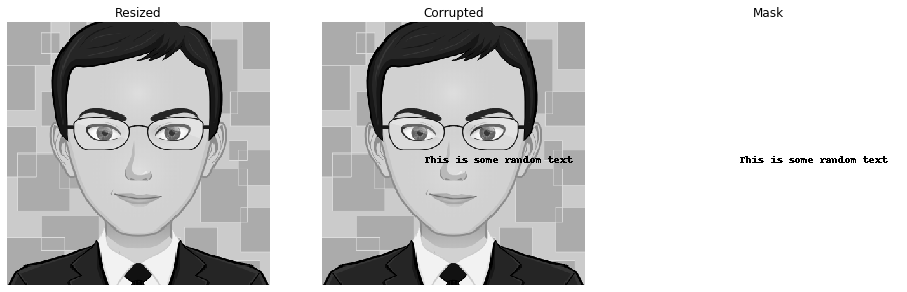

In [7]:
fig=plt.figure(figsize = (16, 16))
plt.subplot(131)
plt.imshow(img)
plt.axis('off')
plt.title('Resized')
plt.subplot(132)
plt.imshow(img_corrupted)
plt.axis('off')
plt.title('Corrupted')
plt.subplot(133)
plt.imshow(mask, cmap='Greys',  interpolation='nearest')
plt.axis('off')
plt.title('Mask')

Now let's imprt the corputed image and analyze it

In [8]:
im=np.array(img)/255
imc=np.array(img_corrupted)/255
msk=np.array(mask)/255

In [9]:
# create a matrix X from overlapping patches
ws = 16 # window size
no_patches = len(im) / ws
N=int(2*no_patches-2)
X = np.zeros((N**2, ws**2), dtype=float)
k = 0
for i in range(0,N):
    for j in range(0,N):
        r1 = np.arange((i)*ws/2,(i+2)*ws/2).astype(int)
        r2 = np.arange((j)*ws/2,(j+2)*ws/2).astype(int)
        patch = imc[r1[0]:r1[-1]+1, r2[0]:r2[-1]+1]
        X[k] = patch.flatten()
        k = k + 1

In [ ]:
# apply Robust PCA
lam = 0.02
mu=1
tol=1e-5
[L, S] = RobustPCA(X, lam, mu,tol);

In [312]:
# reconstruct the image from the overlapping patches in matrix L
img_reconstructed = np.zeros(np.shape(im))
img_noise = np.zeros(np.shape(im))